In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn import preprocessing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# local imports
import NN
import descriptive as de
import loading_data as ld

try: os.mkdir("plots")
except FileExistsError: pass

np.set_printoptions(suppress=True)

Using TensorFlow backend.


In [11]:
def OLS_global(index):        
    stock_index, weather = ld.load_data_OLS(stock_path, weather_path, index)

    # GENERAGE SEASON BINARIES
    stock_index['weekday'] = stock_index.index.dayofweek
    stock_index['month'] = stock_index.index.month

    # Mondays are bad ^^
    stock_index['Monday'] = np.where(stock_index['weekday'] == 0, 1, 0)

    # Winter is November, December, October
    stock_index['Winter'] = np.where((stock_index['month'] == 11) | 
                           (stock_index['month'] == 12) | 
                           (stock_index['month'] == 1), 1, 0)

    # Creating weather binaries for each city
    cities = dict() 
    for city in weather['City'].unique():

        city_name = city

        city = weather[weather['City'] == city].copy()

        city['VeryCold'] = np.where(city['Mean Temperature Actual'] <= np.percentile(city['Mean Temperature Actual'], q=25), 1, 0)
        city['HeavyRain'] = np.where(city['Precipitation Actual'] >= np.percentile(city['Precipitation Actual'], q=75), 1, 0)
        city['ColdRain'] = city['HeavyRain']*city['VeryCold']

        cities[city_name] = city

    # creating global weather binaries that are only true if it's in every location
    stock_index['global_cold'] = np.ones(len(stock_index))
    stock_index['global_rain'] = np.ones(len(stock_index))
    stock_index['global_coldrain'] = np.ones(len(stock_index))

    for city_name, city in cities.items():
        stock_index['global_cold'] = (stock_index['global_cold'] == 1) & (city['VeryCold'] == 1)
        stock_index['global_rain'] = (stock_index['global_rain'] == 1) & (city['HeavyRain'] == 1)
        stock_index['global_coldrain'] = (stock_index['global_coldrain'] == 1) & (city['ColdRain'] == 1)
        
    # convert to integers
    stock_index['global_cold'] = stock_index['global_cold'] * 1
    stock_index['global_rain'] = stock_index['global_rain'] * 1 
    stock_index['global_coldrain'] = stock_index['global_coldrain'] * 1

    # calculating log returns
    stock_index['LogReturns'] = np.log(stock_index['Price Close'] / stock_index['Price Close'].shift(1))

    # doing the regression
    regressors = ['global_cold', 'global_rain', 'global_coldrain', 'weekday', 'month', 'Monday', 'Winter']
    model, predictions = estimate_linear(stock_index.dropna(), 'LogReturns', regressors)

    plot_and_save_stats(model, index)


def estimate_linear(df, dependent, regressors):
    y = df[dependent]
    X = sm.add_constant(df[regressors])
    model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':20})
    predictions = model.predict(X)
    return model, predictions


def plot_and_save_stats(model, name):
    plt.close()
    plt.rc('figure', figsize=(12, 7))
    plt.text(0.01, 0.05, model.summary(), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}_OLS_results.png'.format(name))

In [12]:
# loading the data
weather_path = "./data/Weather_ALL.csv"
stock_path = "./data/StockIndices.csv"

index = "SPX"
# options: SSMI, SPX, NDX, IXIC, SSMI, N225, FTSE

city = "New York"
# options: Boston, Chicago, London, New York, San Francisco, Zurich

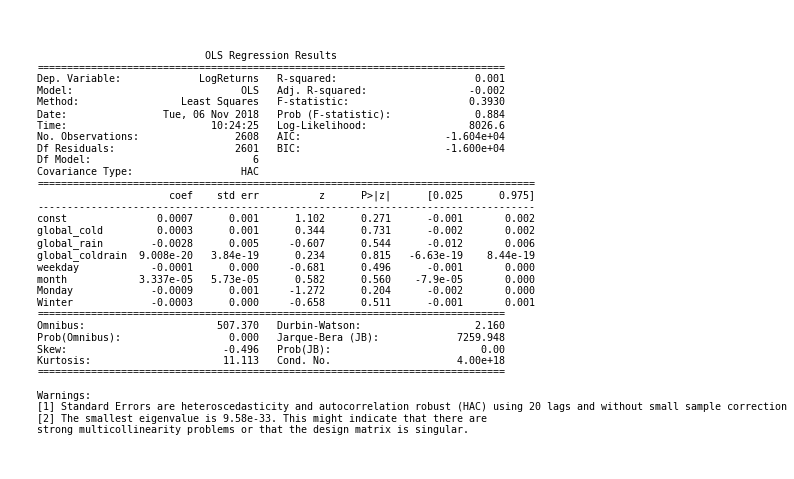

In [13]:
OLS_global(index)